# **Data analysis and prediction of ETFs**

dataset link:https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data

In [ ]:
NG

In [ ]:
import pandas as pd
import numpy as np
import itertools
import time
import random
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import sys
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from scipy.stats import normaltest
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
df = pd.read_csv('acwx.us.txt')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
print(df.index.min(), df.index.max())
df.head()

2008-03-31 00:00:00 2017-11-10 00:00:00


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2008-03-31,42.352,42.352,42.352,42.352,355,0
2008-04-01,54.742,54.742,42.873,43.254,1306,0
2008-04-02,43.667,43.816,43.667,43.675,2368,0
2008-04-03,43.885,44.095,43.885,44.061,2078,0
2008-04-04,48.468,48.468,44.012,44.171,1994,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2424 entries, 2008-03-31 to 2017-11-10
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Open     2424 non-null   float64
 1   High     2424 non-null   float64
 2   Low      2424 non-null   float64
 3   Close    2424 non-null   float64
 4   Volume   2424 non-null   int64  
 5   OpenInt  2424 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 132.6 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,2424.000000,2424.000000,2424.000000,2424.000000,2.424000e+03,2424.0
mean,37.387572,37.575870,37.151788,37.371637,4.235164e+05,0.0
std,5.683557,5.635662,5.743403,5.671066,5.989586e+05,0.0
min,18.624000,19.054000,18.531000,18.725000,1.180000e+02,0.0
25%,34.112500,34.257750,33.866250,34.062500,1.030380e+05,0.0
50%,37.965000,38.088500,37.788000,37.953500,2.329025e+05,0.0
75%,41.409250,41.543000,41.194500,41.404250,5.072955e+05,0.0
max,55.729000,57.413000,49.490000,49.635000,7.373774e+06,0.0


In [ ]:
df = df.drop(columns=['OpenInt'])

No missing data or null data, Delete the 'OpenInt' column that is all zeros

#EDA

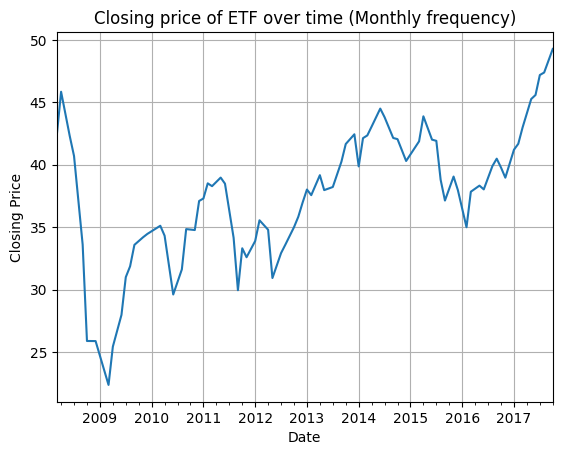

In [ ]:
df["Close"].asfreq('M').interpolate().plot()
plt.title('Closing price of ETF over time (Monthly frequency)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

This chart shows the market performance of ETFs during and after the financial crisis (2008-2018). The market was volatile during the financial crisis (2008), but has since stabilized.

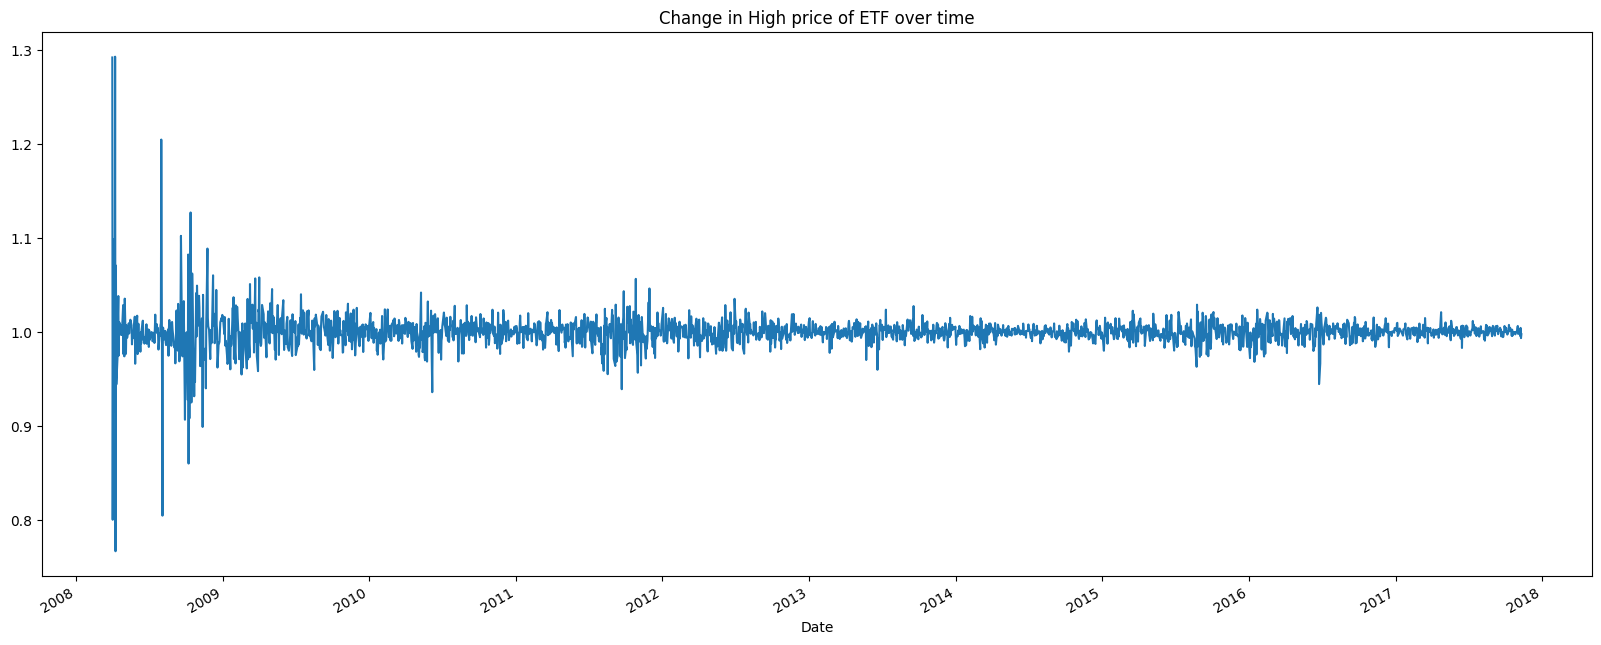

In [ ]:
df['Change'] = df.High.div(df.High.shift())
df['Change'].plot(figsize=(20,8))
_ = plt.title('Change in High price of ETF over time')

The chart shows the changes in ETF trading volume between 2008 and 2018. Trading volume fluctuated sharply during the 2008 financial crisis, then gradually stabilized and the overall trading volume changes decreased.

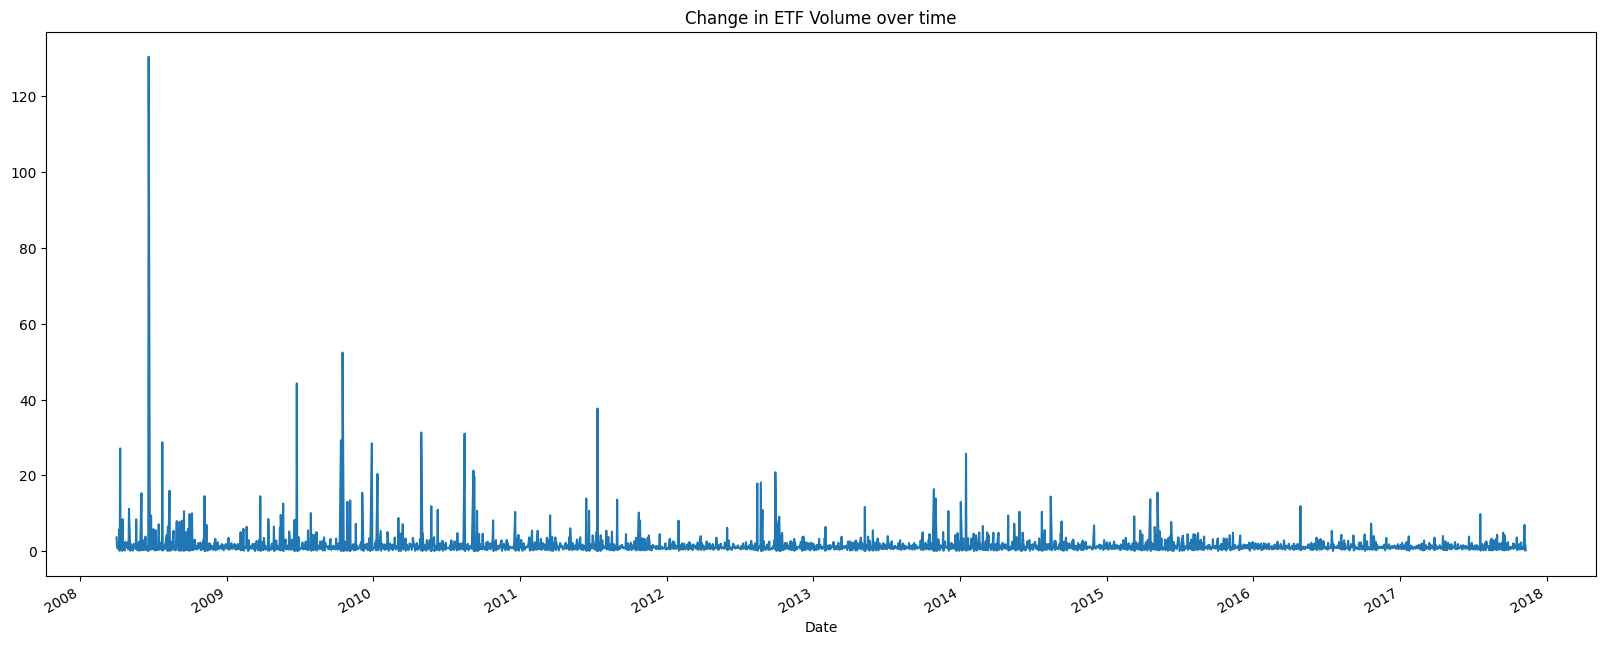

In [ ]:
df['Volume_Change'] = df.Volume.div(df.Volume.shift())
df['Volume_Change'].plot(figsize=(20,8))
_ = plt.title('Change in ETF Volume over time')

This time series is non-stationary. This is because the rolling mean shows an upward trend, the rolling standard deviation shows volatility, and the p-value of the ADF test is greater than 0.05 and the test statistic is greater than the critical value.

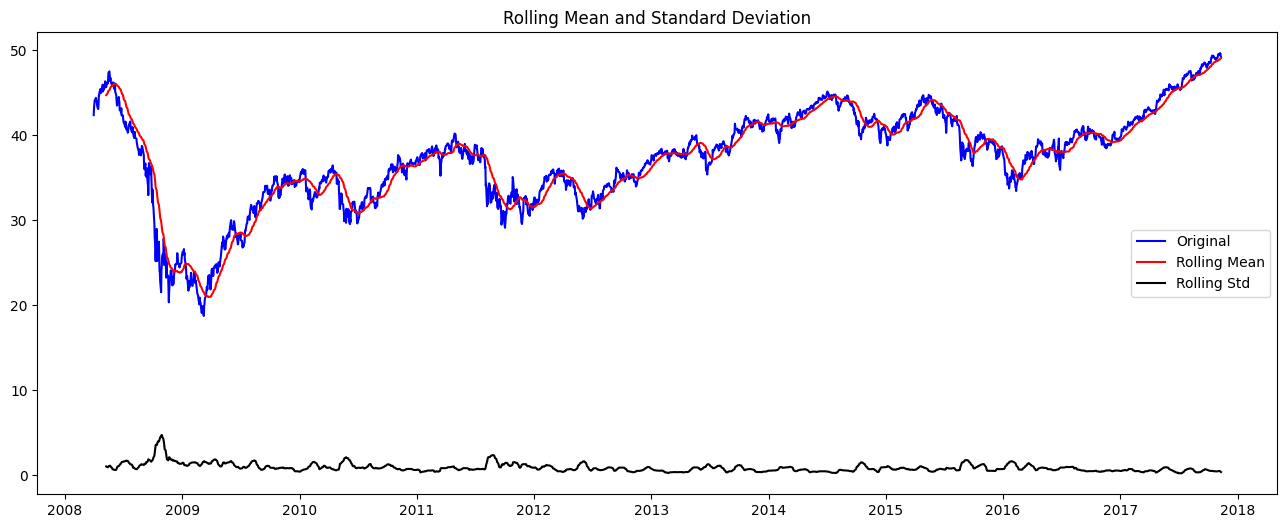

Results of dickey fuller test
Test Statistics                  -1.757660
p-value                           0.401676
No. of lags used                 20.000000
Number of observations used    2403.000000
critical value (1%)              -3.433074
critical value (5%)              -2.862744
critical value (10%)             -2.567411
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.figure(figsize=(16,6))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()

    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df.Close)

Dickey-Fuller Test Results:

Based on the p-value and the test statistic, the series is likely non-stationary, as the p-value is high and the test statistic doesn't meet the required critical value.

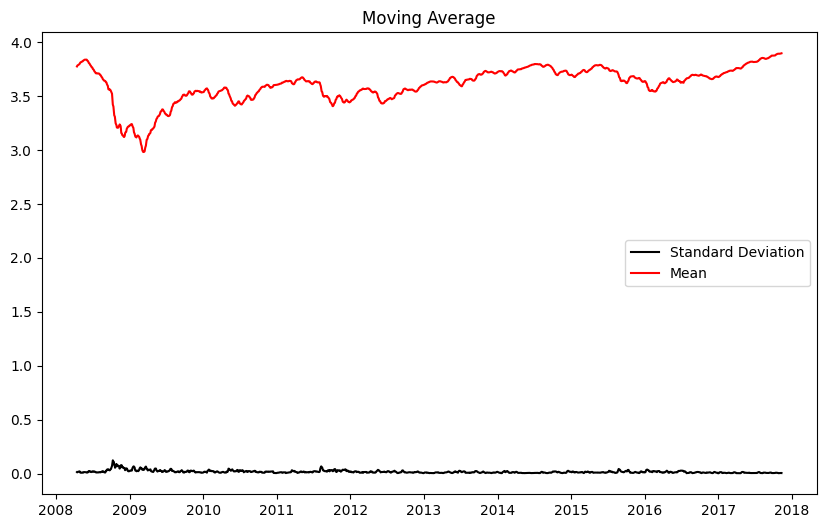

In [ ]:
# Expanding window functions
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Mean (Red Line): The red line represents the moving average over a 12-period window, showing the smoothed version of the time series. The trend suggests a noticeable upward movement starting around 2012, indicating a shift in the data pattern.

Standard Deviation (Black Line): The black line represents the rolling standard deviation over 12 periods. In this plot, the standard deviation remains quite low at the beginning, indicating stability in the data, but then starts to increase significantly around 2012. This increase in standard deviation suggests that the variability or volatility of the data is rising over time.

Candlestick chart

In [ ]:
import plotly.graph_objects as go
from plotly.offline import iplot
# Candlestick chart
trace = go.Candlestick(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
data = [trace]
print('OHLC price chart (Candlestick) of ETF')
iplot(data, filename='simple_candlestick')

OHLC price chart (Candlestick) of ETF


As the number of lags increases, the autocorrelation coefficient gradually decreases, indicating that the closing price has strong autocorrelation in the short term, but the correlation weakens over time.

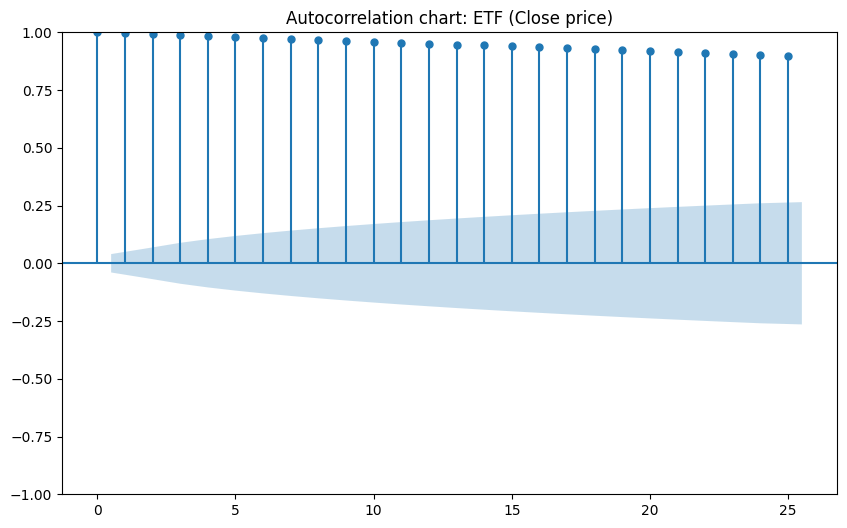

In [ ]:
# Autocorrelation of Closing price of etf
plot_acf(df["Close"],lags=25,title="Autocorrelation chart: ETF (Close price)")
plt.show()

The seasonal component shows the cyclical fluctuations. As can be seen from the figure, the seasonal component shows regular fluctuations within a 30-day period.

Decomposing closing price of Oracle over time


<Figure size 1800x1000 with 0 Axes>

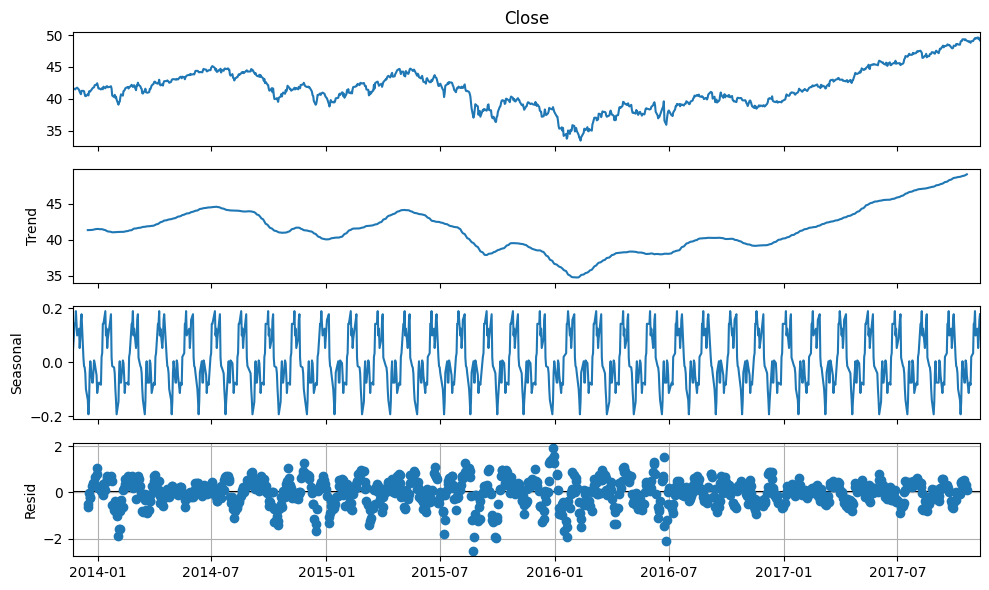

In [ ]:
# Now, for decomposition...
print('Decomposing closing price of Oracle over time')
res = seasonal_decompose(df['Close'][-1000:], model='additive', period=30)
plt.figure(figsize=(18,10))
res.plot()
plt.grid(True)
plt.show()

In this part, we decompose Oracle's stock closing price into its trend, seasonality, and residuals, helping to identify patterns and underlying behaviors in the stock price movements.

Trend Component:The trend declines slightly before increasing again in the later years.

Seasonal Component:The periodic fluctuations suggest a seasonal cycle in stock prices.

Residual (Noise) Component:The residuals appear to be randomly scattered, indicating how much of the variation is unexplained.










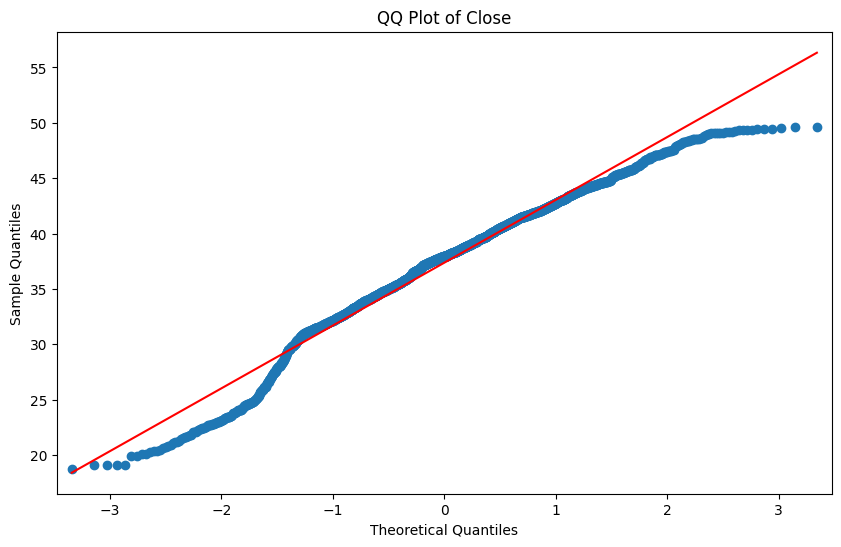

In [ ]:
sm.qqplot(df.Close, line='s')
plt.title('QQ Plot of Close')
plt.show()

The QQ Plot shows that the data is likely to follow normal distribution, because the curve of sample quantities is basically close to the straight line.

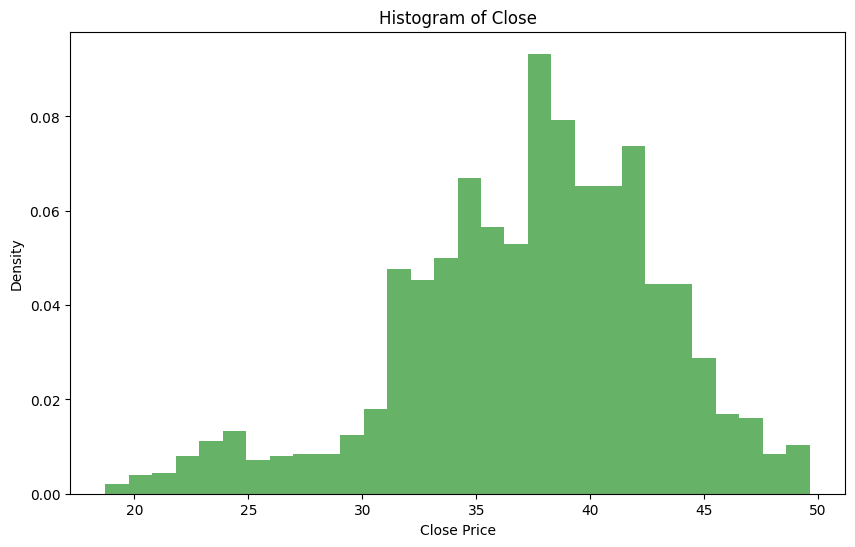

In [ ]:
plt.hist(df.Close, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Close')
plt.xlabel('Close Price')
plt.ylabel('Density')
plt.show()

This chart shows that most close prices are within the range from 31 to 44.

#ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

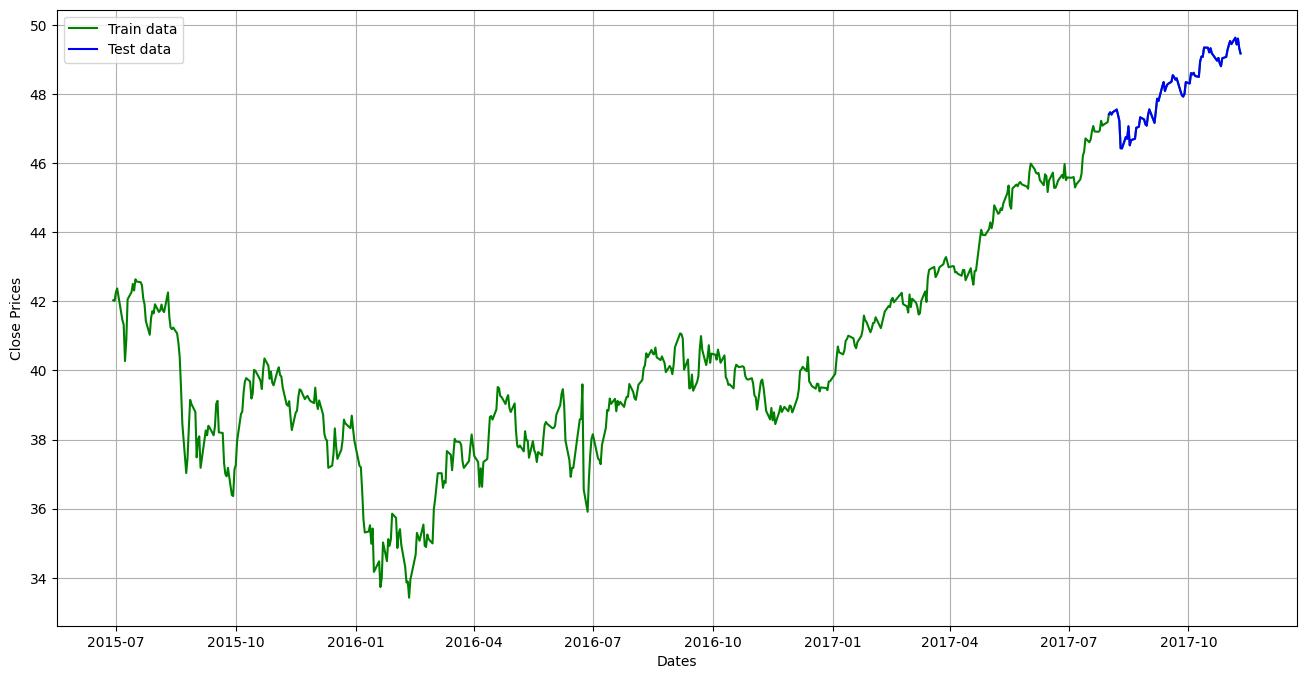

In [ ]:
train_data, test_data = df['Close'][0:-73], df['Close'][-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'].tail(600), 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
history = [x for x in train_data]
y = test_data
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

In [ ]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2423
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1682.469
Date:                Thu, 27 Feb 2025   AIC                           3370.939
Time:                        16:39:39   BIC                           3388.316
Sample:                             0   HQIC                          3377.258
                               - 2423                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5887      0.119      4.960      0.000       0.356       0.821
ma.L1         -0.6413      0.109     -5.858      0.000      -0.856      -0.427
sigma2         0.2349      0.003     68.687      0.0

Both the AR(1) term ( ar.L1 = 0.5887 ) and MA(1) term ( ma.L1 = -0.6413 ) have p-values = 0.000, indicating strong statistical significance. This means the model successfully captures:

Autoregressive (AR) effect: The current value depends on its immediate past value.

Moving Average (MA) effect: Past forecast errors significantly influence future predictions.

The sigma (residual variance) = 0.2349 is small, suggesting tight prediction intervals and stable forecasts.

Ljung-Box Q-statistic (Q=0.09): The near-zero value implies no residual autocorrelation, meaning the model accounts for most time-dependent patterns in the data.

AIC/BIC Values: Relatively low values (AIC=3370.939, BIC=3388.316) indicate a good balance between model complexity and fit.



In [ ]:
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 0.048145052027544606
MAE: 0.16681731192122956
RMSE: 0.2194198077374616


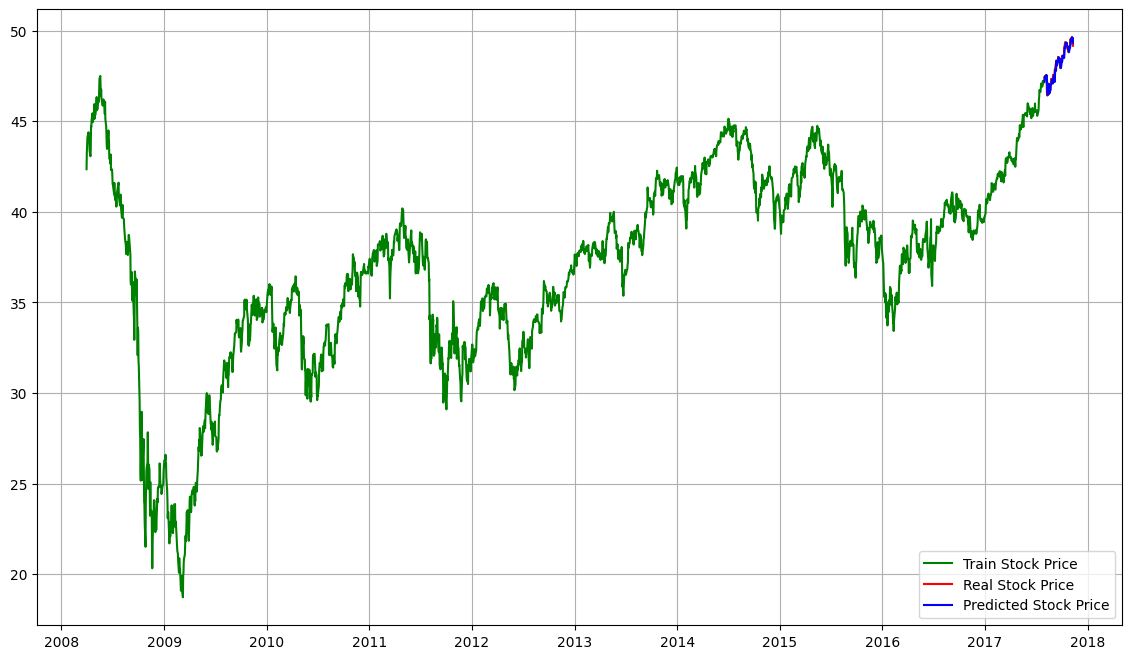

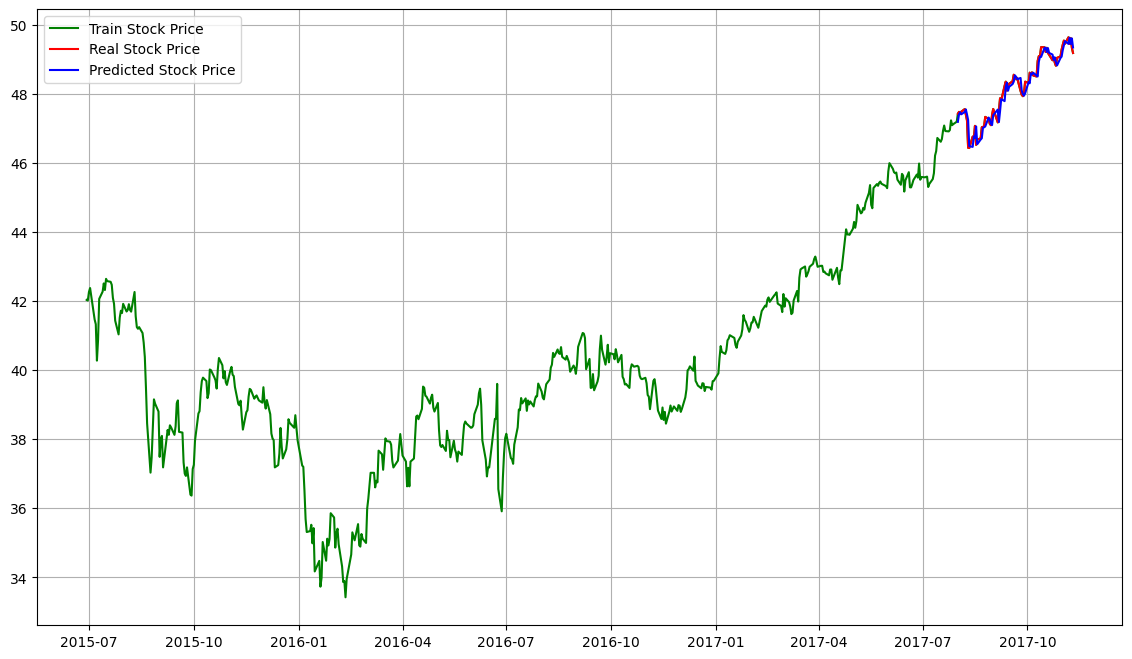

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df.index, df['Close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(df.index[-600:], df['Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

This chart shows stock price in the training dataset, real stock price and the predicted stock price. The result is that the predicted stock price matches the real one well by ARIMA model.
ARIMA(1,1,1) works adequately here due to its simplicity, statistical rigor, and ability to handle trends. However, its limitations in flexibility and lack of error metrics mean it should be treated as a baseline model. Next steps should focus on quantifying performance, testing alternatives,and ensuring consistency in modeling.

#SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1, 1, 1, 30))
model_fitted = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
print(model_fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 2351
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood               -1700.076
Date:                            Thu, 27 Feb 2025   AIC                           3410.151
Time:                                    16:41:17   BIC                           3438.898
Sample:                                         0   HQIC                          3420.627
                                           - 2351                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5732      0.143      4.005      0.000       0.293       0.854
ma.L1         -0.6255      0.133   

The SARIMAX model appears to fit the data well, with significant coefficients for both the AR and MA terms, both in the seasonal and non-seasonal components. The diagnostic tests suggest that the residuals show no significant autocorrelation but deviate from normality and might exhibit heteroskedasticity. The AIC and BIC values are reasonable, and the model seems to capture both the trend and seasonality of the time series effectively.

#LSTM

In [ ]:
train_data, test_data = df[0:-73], df[-73:]

In [ ]:

train = train_data['Close'].values
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
# Train dataset
timesteps = 10
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [ ]:
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 16)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0499
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0058
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0056
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0045
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0041
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0040
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0042
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0039
Epoch 9/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0036
Epoch 10/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0034


In [ ]:
# this will be used later while comparing and visualization
real_stock_price = test_data['Close'].values # taking open price
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


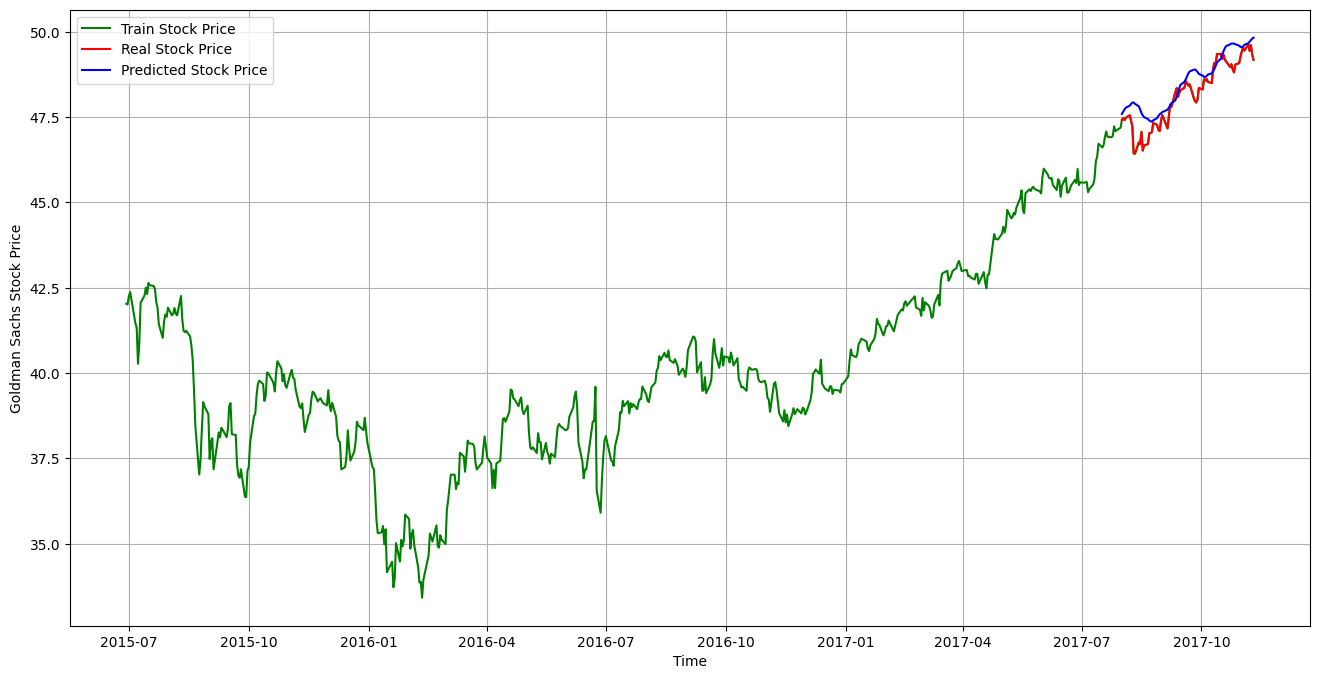

MSE: 0.2671283355758576
MAE: 0.3991727687887949
RMSE: 0.5168445951887836


In [ ]:

plt.figure(figsize=(16,8))
plt.plot(df.index[-600:], df['Close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
#plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

This chart shows stock price in the training dataset, real stock price and the predicted stock price. The result is that LSTM model causes a relatively large error and does not perform as well as previous models.This may be caused by:

Overfitting Risk:
LSTM’s complexity could lead to memorizing noise in the training data (green curve), reducing generalization to the test set.

Unnecessary Nonlinear Capacity:
The stock price trend here is mostly linear, making LSTM’s nonlinear activation functions (e.g., tanh, sigmoid) redundant.

Hyperparameter Sensitivity:
LSTMs require precise tuning of layers, learning rates, and sequence lengths. Suboptimal choices can degrade performance.

ARIMA outperformed LSTM in this task due to the linearity of trends, limited dataset size, and short-term forecasting requirements. While LSTM is powerful for complex sequences, its advantages are unnecessary here. ARIMA’s simplicity, efficiency, and interpretability make it the better choice for this specific scenario.